In [4]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime

#import selenium
#from selenium import webdriver
from time import sleep

import quandl

import seaborn as sns

import sys

from scipy.stats import norm

In [5]:
def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
 
    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                 float(ES)]},
                   index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'ES'])
    

    
    return metrics 

In [6]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [7]:
def backtest_strategy(data, W, tol, rebalance_freq, data_names, leverage = 1):
    initial = 1
    asset = [i * initial for i in W]
    port = []
    port_W = [] 

    if sum(W) == 1:

        for i in range(len(data)):
            #port.append(initial)
            port_W.append([i / initial for i in asset])
            
            daily_ret = ((data.iloc[i]-1) * leverage) +1
            asset = asset * daily_ret #data.iloc[i]
            initial = sum(asset)
            port.append(initial)
            #Rebalancing by days
            if i%rebalance_freq == 0:
                for i in range(len(W)):
                    asset[i] = initial * W[i]
            
            #Rebalancing by deviation
            for i in range(len(asset)):
                if abs(asset[i]/initial - W[i])> tol:  
                      asset = [i * initial for i in W]
    
        port = pd.DataFrame(port)
        port.index = data.index
    
        result = pd.concat([port, data.cumprod()], axis =1)
        result.columns = ["Portfolio"] + data_names
        
        return (result, port_W)
        
    else:
        print("Weight not Equal to 1!")

In [8]:
def strategy_evaluation(result, data_names, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino' ],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'ES'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.2%}", 'Max DD': "{:.2%}", 'ES': "{:.2%}", 'Volatility': "{:.2%}"})
      .set_table_styles(styles))
    
    return metrics

In [9]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    th_props = [
      ('font-size', '11px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '11px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .set_table_styles(styles))
    
    return corr

# Backtesting Portfolio

TODO:
- collect data, dividned adjusted
- leverage
- start and end date

In [10]:
SP500_daily_tmp = yf.download("^SP500TR")
SHY_daily_tmp = yf.download("SHY")
TLT_daily_tmp =  yf.download("TLT")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
SP500_daily= pd.DataFrame(SP500_daily_tmp['Close'])
SHY_daily = pd.DataFrame(SHY_daily_tmp['Close'])
TLT_daily = pd.DataFrame(TLT_daily_tmp['Close'])

SP500_daily.columns = ['SP500']
SHY_daily.columns = ['SHY']
TLT_daily.columns = ['TLT']

In [12]:
# TYX 30 yr Treasury

TYX_tmp = yf.download('^TYX')

TYX_tmp.insert(1, "TYX", 0.0, True)
ttm = 30
price = 100.0
prev_price = 0
row = 0

for i in TYX_tmp['Close']:
    TYX_tmp['TYX'][row] = price
    curr_price = 1/(1+i/100)**ttm
    if prev_price == 0: 
        price_change = 0
    else: 
        price_change = (curr_price-prev_price)/prev_price
    imp_yield = (price*(1+i/100)-price)/252
    price = price*(1+price_change) + imp_yield
    prev_price = curr_price
    row += 1
    
TYX = pd.DataFrame(TYX_tmp['TYX'])

[*********************100%***********************]  1 of 1 completed


/Users/davidboman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [13]:
# TNX 10 year gov bond

TNX_tmp = yf.download('^TNX')

TNX_tmp.insert(1, "TNX", 0.0, True)
ttm = 10
price = 100.0
prev_price = 0
row = 0

for i in TNX_tmp['Close']:
    TNX_tmp['TNX'][row] = price
    curr_price = 1/(1+i/100)**ttm
    if prev_price == 0: 
        price_change = 0
    else: 
        price_change = (curr_price-prev_price)/prev_price
    imp_yield = (price*(1+i/100)-price)/252
    price = price*(1+price_change) + imp_yield
    prev_price = curr_price
    row += 1
    
TNX = pd.DataFrame(TNX_tmp['TNX'])

[*********************100%***********************]  1 of 1 completed


/Users/davidboman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [14]:
# FVX 5 year gov bond

FVX_tmp = yf.download('^FVX')

FVX_tmp.insert(1, "FVX", 0.0, True)
ttm = 5
price = 100.0
prev_price = 0
row = 0

for i in FVX_tmp['Close']:
    FVX_tmp['FVX'][row] = price
    curr_price = 1/(1+i/100)**ttm
    if prev_price == 0: 
        price_change = 0
    else: 
        price_change = (curr_price-prev_price)/prev_price
    imp_yield = (price*(1+i/100)-price)/252
    price = price*(1+price_change) + imp_yield
    prev_price = curr_price
    row += 1
    
FVX = pd.DataFrame(FVX_tmp['FVX'])

[*********************100%***********************]  1 of 1 completed


/Users/davidboman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [15]:
#Gold Import
Gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")

In [16]:
Gold = pd.DataFrame(Gold_tmp["USD (AM)"])
Gold_monthly = Gold.resample('M').last()
Gold.columns = ['Gold']
Gold_monthly.columns = ['Gold']

In [17]:
#Long Vol Import
long_vol_imp = pd.read_excel (r'https://www.eurekahedge.com/Indices/ExportIndexReturnsToExcel?IndexType=Eurekahedge&IndexId=640')

long_vol = long_vol_imp[3:]
long_vol.index= pd.to_datetime(long_vol_imp[3:]['Unnamed: 0'])
long_vol = pd.DataFrame(long_vol['Unnamed: 2'])
long_vol.columns = ["Long Vol"]

In [18]:
#Monthly SP500
SP500_monthly = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="6rNSyTM5R4g7_B7XSyQW")
SP500_monthly.columns = ['SP500']

In [34]:
####DAILY DATA#########

data = pd.concat([SP500_daily,Gold], axis = 1) #asset_2, asset_4
data = data.ffill()
data = data.dropna()
data = data/data.shift(1)
data = data.fillna(1)

In [35]:
######## Monthly Data

data_tmp = pd.concat([SP500_monthly, long_vol], axis = 1)
data_tmp = data_tmp.ffill()
data_tmp = data_tmp.dropna()
monthly_data = data_tmp/data_tmp.shift()
monthly_data = monthly_data.fillna(1)
monthly_data = monthly_data.ffill()
monthly_data = monthly_data.dropna()

In [36]:
rebalance_freq = 252/4
tol = 0.1
W = [1/2, 1/2]

data_names = data.columns.tolist()


result, weights = backtest_strategy(data, W, tol, rebalance_freq, data_names, leverage = 1)

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,ES
Portfolio,7.86%,11.80%,0.670000,0.870000,-34.00%,0.230000,1.50%
SP500,10.33%,17.90%,0.580000,0.690000,-55.00%,0.190000,2.30%
Gold,4.12%,15.60%,0.260000,0.340000,-48.00%,0.090000,2.00%


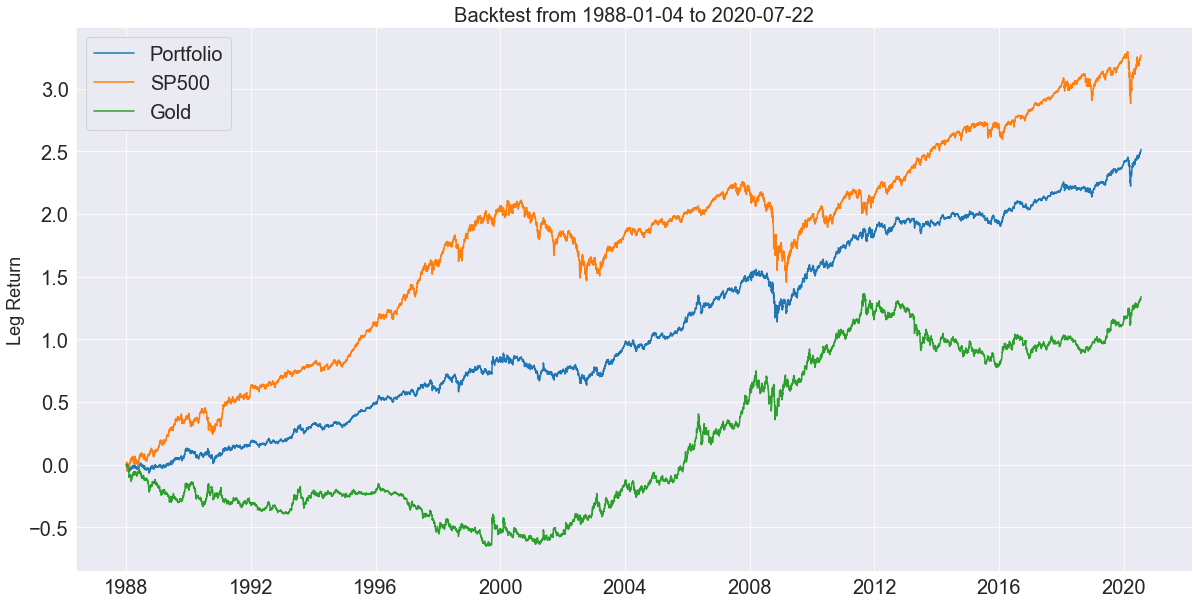

In [37]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result.columns:
    plt.plot(np.log(result[i]), label = i);

start = datetime.date(result.index.min());
end = datetime.date(result.index.max());
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.ylabel('Leg Return', fontsize=18)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

strategy_evaluation(result, data_names, freq = 'D')


In [38]:
correlation_map(result)

,Portfolio,SP500,Gold
Portfolio,1.000000,0.738922,0.673960
SP500,0.738922,1.000000,0.003476
Gold,0.673960,0.003476,1.000000
